In [1]:
# Import main packages
import sys, os
sys.path.insert(1, os.path.abspath('..') )
from ECO import diagnostics as eco
from ECO.utils import config_parser, open_datasets, get_namelist
import xarray as xr
import xgcm
import numpy as np

# Import matplotlib for plotting and functions to override default values
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from plot_utils import update_plotstyle, cmap_OB
cmap_OB=cmap_OB(); update_plotstyle()

In [3]:
exp_prefix = ['EXP00','EXP01','EXP02'] # Import all files with this prefix
exp_suffix = ['_1d10','_1d10','_1d10']
ds = open_datasets(exp_prefix, exp_suffix, components = ['all'],timestep_slice=(0,360))
if type(ds) != dict: ds={exp_prefix+exp_suffix:ds}

[PosixPath('../data/processed/EXP00/EXP00_1d10/domain/metrics_0_360.nc'), PosixPath('../data/processed/EXP00/EXP00_1d10/domain/masks_0_360.nc')]


HDF5-DIAG: Error detected in HDF5 (1.12.2) MPI-process 0:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 476 in H5O__attr_open_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #006: H5Adense.c line 394 in H5A__dense_open(): can't locate attribute in name index
    major: Attribute
    minor: Object

[PosixPath('../data/processed/EXP01/EXP01_1d10/domain/metrics_0_360.nc'), PosixPath('../data/processed/EXP01/EXP01_1d10/domain/masks_0_360.nc')]


HDF5-DIAG: Error detected in HDF5 (1.12.2) MPI-process 0:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 476 in H5O__attr_open_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #006: H5Adense.c line 394 in H5A__dense_open(): can't locate attribute in name index
    major: Attribute
    minor: Object

[PosixPath('../data/processed/EXP02/EXP02_1d10/domain/metrics_0_360.nc'), PosixPath('../data/processed/EXP02/EXP02_1d10/domain/masks_0_360.nc')]


HDF5-DIAG: Error detected in HDF5 (1.12.2) MPI-process 0:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 476 in H5O__attr_open_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #006: H5Adense.c line 394 in H5A__dense_open(): can't locate attribute in name index
    major: Attribute
    minor: Object

In [4]:
%matplotlib inline
# get base configuration of EXP00
kwargs={}
#kwargs[exp_prefix+exp_suffix] = config_parser(exp_prefix)
for i in range(len(exp_prefix)): kwargs[exp_prefix[i]+exp_suffix[i]] = config_parser(exp_prefix[i])
#if kwargs_sim['get_namelist']: kwargs_sim['namelist'] = get_namelist(path = kwargs_proc['path_nemo'])

# define xgcm configuration based on dataset metrics
_metrics = {('X',): ['e1tm', 'e1um', 'e1vm', 'e1fm'],
     ('Y',): ['e2tm', 'e2um', 'e2vm', 'e2fm'],
     ('Z',): ['e3tm', 'e3um', 'e3vm', 'e3wm']}

grid = {exp: xgcm.Grid(ds[exp], metrics=_metrics, periodic=False) for exp in ds} # define xgcm grid
grid_ops = {exp: eco.Grid_ops(grid[exp], maskargs={'mask':'nan'}) for exp in ds} # define gridoperations.
grid = {exp: grid_ops[exp]._update({'Z':ds[exp]['e3tm_1d']}) for exp in ds}
        
properties= {exp: eco.Properties(grid_ops[exp], {'X': ds[exp].glamt, 'Y': ds[exp].gphit, 'Z': ds[exp].depth_1d}, eos_properties=kwargs[exp][2]['eos']) for exp in ds}
energetics= {exp: eco.Energetics(grid_ops[exp], properties[exp]) for exp in ds}

Using processing configuration base.yml
Using processing configuration base.yml
Using processing configuration base.yml


In [5]:
phi = ds['EXP00_1d10'].gphit[:,0]
lam = ds['EXP00_1d10'].glamt[0,:]
depth = properties['EXP00_1d10'].coords['Z']
YZ,ZY = np.meshgrid(phi.values,depth.values[:-1])
XY,YX = np.meshgrid(lam.values,phi.values)

In [6]:
h = {exp: energetics[exp].dynamic_enthalpy(ds[exp].to, ds[exp].so, ds[exp]['depth'], Z_r=ds[exp].zg_0)/9.81 for exp in ds}
h_vm = {exp: grid_ops[exp].average(h[exp], 'Z') for exp in ds}
h_gm = {exp: energetics[exp].dynamic_enthalpy(ds[exp].t_gm, ds[exp].s_gm, ds[exp]['depth'], Z_r=ds[exp].zg_0)/9.81 for exp in ds}
h_gm_vm = {exp: grid_ops[exp].average(h_gm[exp], 'Z') for exp in ds}
zeta_xy = {exp: grid_ops[exp].average(h[exp], ['X','Y']).mean('t')-grid_ops[exp].average(h_gm[exp], ['X','Y']).mean('t').compute() for exp in ds}
zeta_xz = {exp: grid_ops[exp].average(h[exp], ['X','Z']).mean('t')-grid_ops[exp].average(h_gm[exp], ['X','Z']).mean('t').compute() for exp in ds}

/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


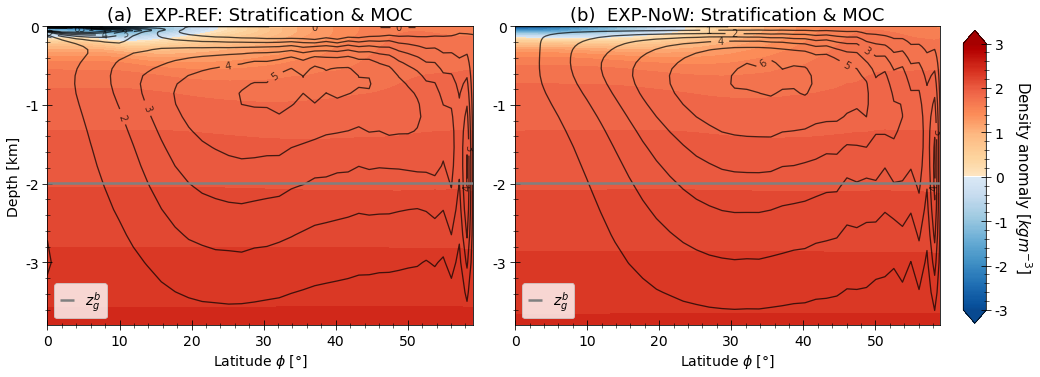

In [56]:
fig, ax = plt.subplots(1,2,figsize=(16,5.5))

for i, exp in enumerate(ds):
    dn = grid_ops[exp].average(ds[exp].rho-1026,'X').mean('t')#.values-1000
    vmin = -3
    vmax = 3
    qcs=ax[i].contourf(YZ, ZY, dn[:-1], cmap=cmap_OB,extend='both', levels=np.linspace(-3,3,41))
    

    vmin=-6
    vmax=6
    c = ax[i].contour(YZ, ZY, ds[exp].psi.mean('t')[:-1], colors='k',levels=np.linspace(0,6,7),linewidths=1.3,alpha=.7)
    ax[i].hlines(ds[exp].zg_0.mean('t'),0,60, color='grey',label='$z_g^b$')
    ax[i].clabel(c)
    #ax[i].set_title('(b) Meridional overturning circulation',fontsize=18)
    ax[i].set_xlabel('Latitude $\phi$ [°]',fontsize=14)
    ax[i].set_yticks([-4000,-3000,-2000,-1000,0])
    ax[i].set_yticklabels([0,-1,-2,-3,-4][::-1])
    ax[i].set_ylim(-3800,0)
    ax[i].set_xlim(0,59) 

    prefix = ['(a)  ','(b)  '] 
    prefix1 = ['EXP-REF: ','EXP-NoW: '] 
    suffix = ['Stratification & MOC', 'Stratification & MOC']
    ax[i].set_title(prefix[i]+prefix1[i]+suffix[i],fontsize=18)
    ax[i].legend(fontsize=14,handlelength=1,loc='lower left')
ax[0].set_ylabel('Depth [km]',fontsize=14)
ax_cb=fig.add_axes([0.92, 0.13, 0.02, 0.74])
cbar=plt.colorbar(ScalarMappable(norm=qcs.norm, cmap=qcs.cmap),ax=ax_cb,cax=ax_cb,
             ticks=np.arange(vmin, vmax+1, 1),
             extend='both', pad=0.02)

cbar.set_ticklabels(cbar.get_ticks())
#cbar.set_label('$\Psi_{moc}$ [Sv]',rotation=-90,labelpad=25,fontsize=15)
cbar.set_label(r'Density anomaly [$kg m^{-3}$]',rotation=-90,labelpad=25,fontsize=15)

plt.subplots_adjust(wspace=0.1)
plt.savefig('figures/Fig4_final.png', dpi=150, transparent=True, bbox_inches='tight')

/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


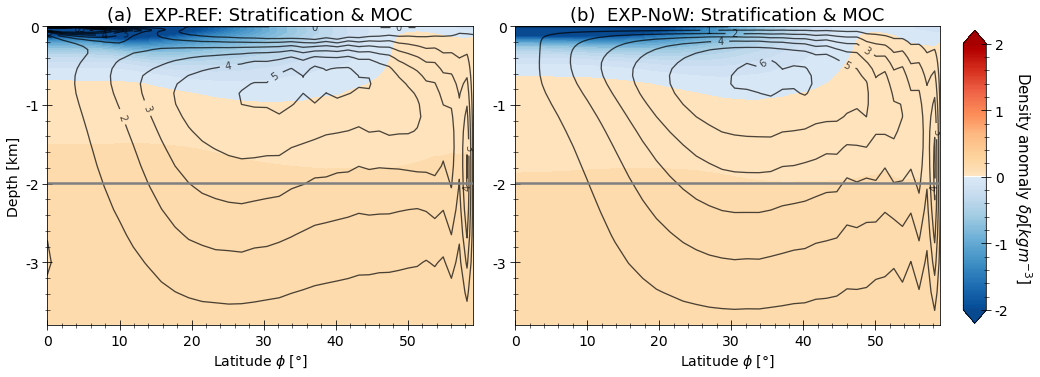

: 

In [6]:
fig, ax = plt.subplots(1,2,figsize=(16,5.5))

for i, exp in enumerate(ds):
    if i==2: continue
    drho = ds[exp].rho-ds[exp].rho_gm
    drho_h = grid_ops[exp].average(drho,'X').mean('t')#.values-1000
    vmin = -2
    vmax = 2
    qcs=ax[i].contourf(YZ, ZY, drho_h[:-1], cmap=cmap_OB,extend='both', levels=np.linspace(-2,2,41))
    

    vmin=-6
    vmax=6
    c = ax[i].contour(YZ, ZY, ds[exp].psi.mean('t')[:-1], colors='k',levels=np.linspace(0,6,7),linewidths=1.3,alpha=.7)
    ax[i].hlines(ds[exp].zg_0.mean('t'),0,60, color='grey',label='$z_g^b$')
    ax[i].clabel(c)
    #ax[i].set_title('(b) Meridional overturning circulation',fontsize=18)
    ax[i].set_xlabel('Latitude $\phi$ [°]',fontsize=14)
    ax[i].set_yticks([-4000,-3000,-2000,-1000,0])
    ax[i].set_yticklabels([0,-1,-2,-3,-4][::-1])
    ax[i].set_ylim(-3800,0)
    ax[i].set_xlim(0,59) 

    prefix = ['(a)  ','(b)  '] 
    prefix1 = ['EXP-REF: ','EXP-NoW: '] 
    suffix = ['Stratification & MOC', 'Stratification & MOC']
    ax[i].set_title(prefix[i]+prefix1[i]+suffix[i],fontsize=18)
    # ax[i].legend(fontsize=14,handlelength=1,loc='lower left')
ax[0].set_ylabel('Depth [km]',fontsize=14)
ax_cb=fig.add_axes([0.92, 0.13, 0.02, 0.74])
cbar=plt.colorbar(ScalarMappable(norm=qcs.norm, cmap=qcs.cmap),ax=ax_cb,cax=ax_cb,
             ticks=np.arange(vmin, vmax+1, 1),
             extend='both', pad=0.02)

cbar.set_ticklabels(cbar.get_ticks())
#cbar.set_label('$\Psi_{moc}$ [Sv]',rotation=-90,labelpad=25,fontsize=15)
cbar.set_label(r'Density anomaly $\delta \rho$[$kg m^{-3}$]',rotation=-90,labelpad=25,fontsize=15)

plt.subplots_adjust(wspace=0.1)
plt.savefig('figures/Fig3_new_final.png', dpi=150, transparent=True, bbox_inches='tight')

/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


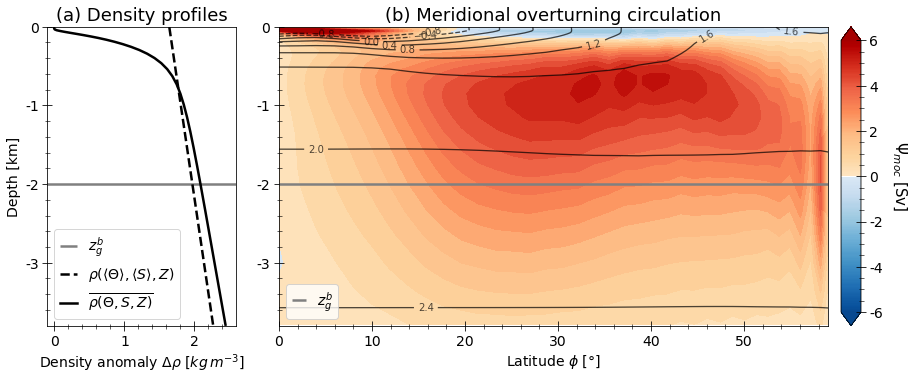

In [55]:
%matplotlib inline 
gs_kw = dict(width_ratios=[1,3.5])
fig, ax = plt.subplots(1,2,figsize=(16,5.5), gridspec_kw=gs_kw)#,constrained_layout=True)#, gridspec_kw=gs_kw)
ax[0],ax[1]=ax[1],ax[0]
lam = ds['EXP00_1d10'].gphit[:,0]
depth = properties['EXP00_1d10'].coords['Z']
X,Y = np.meshgrid(lam.values,depth.values[:-1])

vmin = 25.5
vmax = 28.5#.5
dn = grid_ops['EXP00_1d10'].average(ds['EXP00_1d10'].rho-1026,'X').mean('t')#.values-1000
c=ax[0].contour(X, Y, dn.where(dn>-1)[:-1], colors='k',levels=8,linewidths=1.3,alpha=.7)
ax[0].clabel(c)

vmin=-6
vmax=6
qcs = ax[0].contourf(X,Y, ds['EXP00_1d10'].psi.mean('t')[:-1], cmap=cmap_OB,vmin=vmin,vmax=vmax, levels=35)
ax[0].hlines(ds['EXP00_1d10'].zg_0.mean('t'),0,60, color='grey',label='$z_g^b$')#,linewidth=1)

# ax_cb=fig.add_axes([0.8, 0.13, 0.02, 0.74])
# cbar=plt.colorbar(ScalarMappable(norm=qcs.norm, cmap=qcs.cmap),ax=ax_cb,cax=ax_cb,
#              ticks=np.arange(vmin, vmax+1, 1),
#              extend='both', pad=0.02)
cbar=plt.colorbar(ScalarMappable(norm=qcs.norm, cmap=qcs.cmap),ax=ax[0],
             ticks=np.arange(vmin, vmax+1, 2),
             extend='both', pad=0.02, aspect=15)

cbar.set_ticklabels(cbar.get_ticks())
cbar.set_label('$\Psi_{moc}$ [Sv]',rotation=-90,labelpad=25,fontsize=15)

ax[0].set_title('(b) Meridional overturning circulation',fontsize=18)
ax[0].set_xlabel('Latitude $\phi$ [°]',fontsize=14)
ax[0].set_yticks([-4000,-3000,-2000,-1000,0])
ax[0].set_yticklabels([0,-1,-2,-3,-4][::-1])
ax[0].set_ylim(-3800,0)
ax[0].set_xlim(0,59)
ax[0].legend(fontsize=14,handlelength=1,loc='lower left')

ax[1].set_title('(a) Density profiles',fontsize=18)
ax[1].hlines(ds['EXP00_1d10'].zg_0.mean('t'),-1,3, color='grey',label='$z_g^b$')#,linewidth=1)
ax[1].plot(ds['EXP00_1d10'].rho_gm.mean('t')-1026,depth,c='k',linestyle='--',label=r'$\rho(\langle\Theta\rangle,\langle S\rangle,Z)$')
ax[1].plot(grid_ops['EXP00_1d10'].average(ds['EXP00_1d10'].rho,['X','Y']).mean('t')-1026,depth,c='k',label=r'$\overline{\rho(\Theta,S,Z)}$')
ax[1].set_yticks([-4000,-3000,-2000,-1000,0])
ax[1].set_yticklabels([0,-1,-2,-3,-4][::-1])
ax[1].set_ylim(-3800,0)
ax[1].set_xlim(-0.1,2.6)
ax[1].set_ylabel('Depth [km]',fontsize=14)
#ax[1].set_ylabel('Depth [km]',fontsize=14)
ax[1].set_xlabel(r'Density anomaly $\Delta \rho$ [$kg\,m^{-3}$]',fontsize=14)
ax[1].legend(fontsize=14, handlelength=1.2)
plt.subplots_adjust(wspace=0.1)
plt.savefig('figures/Fig3_final.png', dpi=150, transparent=True, bbox_inches='tight')

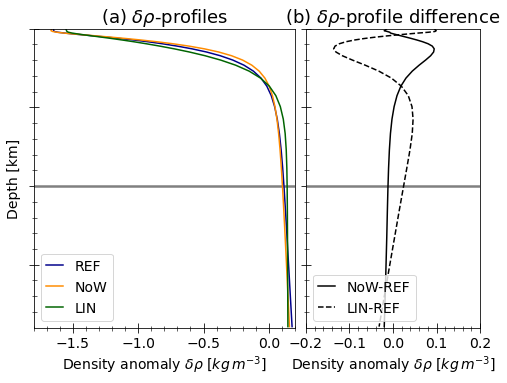

In [63]:
%matplotlib inline 
gs_kw = dict(width_ratios=[1.5,1])
fig, ax = plt.subplots(1,2,figsize=(8,5.5), gridspec_kw=gs_kw)#,constrained_layout=True)#, gridspec_kw=gs_kw)
# ax[0],ax[1]=ax[1],ax[0]
lam = ds['EXP00_1d10'].gphit[:,0]
depth = properties['EXP00_1d10'].coords['Z']
X,Y = np.meshgrid(lam.values,depth.values[:-1])

# ax[0].set_title('(a) Density profiles',fontsize=18)
# ax[0].hlines(ds['EXP00_1d10'].zg_0.mean('t'),-1,3, color='grey',label='$z_v$')#,linewidth=1)
# ax[0].plot(ds['EXP00_1d10'].rho_gm.mean('t')-1026,depth,c='k',linestyle='--',label=r'$\rho(\langle\Theta\rangle,\langle S\rangle,Z)$')
# ax[0].plot(grid_ops['EXP00_1d10'].average(ds['EXP00_1d10'].rho,['X','Y']).mean('t')-1026,depth,c='k',label=r'$\overline{\rho(\Theta,S,Z)}$')

# ax[0].set_xlabel(r'$\overline{\Delta \rho}$ [$kg\,m^{-3}$]',fontsize=14)
# ax[0].legend(fontsize=14, handlelength=1.2)

ax[0].hlines(ds['EXP00_1d10'].zg_0.mean('t'),-3,3, color='grey')#,linewidth=1)
colors = ['darkblue', 'darkorange', 'darkgreen']
labels = [r'REF', r'NoW', r'LIN']
for i, exp in enumerate(ds):
    drho = ds[exp].rho-ds[exp].rho_gm
    drho_h = grid_ops[exp].average(drho,['X','Y']).mean('t')#.values-1000
    ax[0].plot(drho_h,properties[exp].coords['Z'],c=colors[i],label=labels[i], linewidth=1.5)
ax[0].set_yticks([-4000,-3000,-2000,-1000,0])
ax[0].set_yticklabels([0,-1,-2,-3,-4][::-1])
ax[0].set_ylim(-3800,0)
ax[0].set_ylabel('Depth [km]',fontsize=14)
ax[0].set_title(r'(a) $\delta \rho$-profiles',fontsize=18)
ax[0].set_yticks([-4000,-3000,-2000,-1000,0])
ax[0].set_yticklabels([])
ax[0].set_ylim(-3800,0)
ax[0].set_xlim(-1.8,0.2)
# ax[0].set_xticks([-1,-0.5,-0])
ax[0].set_xlabel(r'Density anomaly $\delta\rho$ [$kg\,m^{-3}$]',fontsize=14)
ax[0].legend(fontsize=14, handlelength=1.2, loc='lower left')

ax[1].hlines(ds['EXP00_1d10'].zg_0.mean('t'),-3,3, color='grey')#,linewidth=1)
colors = ['k', 'k', 'k']
styles = ['-', '-', '--']
labels = [r'REF', r'NoW-REF', r'LIN-REF']
for i, exp in enumerate(ds):
    if i==0: continue
    
    drho_ref = ds['EXP00_1d10'].rho-ds['EXP00_1d10'].rho_gm
    drho_ref_h = grid_ops['EXP00_1d10'].average(drho_ref,['X','Y']).mean('t')#.values-1000

    drho = ds[exp].rho-ds[exp].rho_gm
    drho_h = grid_ops[exp].average(drho,['X','Y']).mean('t')#.values-1000
    ax[1].plot(drho_h-drho_ref_h,properties[exp].coords['Z'],c=colors[i],label=labels[i], linewidth=1.5, linestyle=styles[i])

ax[1].set_title(r'(b) $\delta \rho$-profile difference',fontsize=18)
ax[1].set_yticks([-4000,-3000,-2000,-1000,0])
ax[1].set_yticklabels([])
ax[1].set_ylim(-3800,0)
ax[1].set_xlim(-0.2,0.2)
# ax[2].set_xticks([-1,-0.5,-0])
ax[1].set_xlabel(r'Density anomaly $\delta\rho$ [$kg\,m^{-3}$]',fontsize=14)
ax[1].legend(fontsize=14, handlelength=1.2, loc='lower left')

plt.subplots_adjust(wspace=0.05)
plt.savefig('figures/Fig2_new_final.png', dpi=150, transparent=True, bbox_inches='tight')

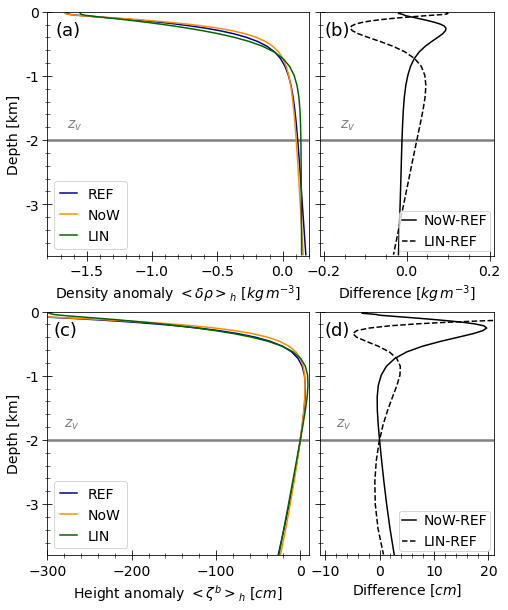

In [36]:
%matplotlib inline 
gs_kw = dict(width_ratios=[1.5,1])
fig, ax = plt.subplots(2,2,figsize=(8,10), gridspec_kw=gs_kw)
lam = ds['EXP00_1d10'].gphit[:,0]
depth = properties['EXP00_1d10'].coords['Z']
X,Y = np.meshgrid(lam.values,depth.values[:-1])

ax[0,0].hlines(ds['EXP00_1d10'].zg_0.mean('t'),-3,3, color='grey')#,linewidth=1)
ax[0,0].text(-1.65, -1800, '$z_v$', fontsize=14, c='grey')
colors = ['darkblue', 'darkorange', 'darkgreen']
labels = [r'REF', r'NoW', r'LIN']
for i, exp in enumerate(ds):
    drho = ds[exp].rho-ds[exp].rho_gm
    drho_h = grid_ops[exp].average(drho,['X','Y']).mean('t')#.values-1000
    ax[0,0].plot(drho_h,properties[exp].coords['Z'],c=colors[i],label=labels[i], linewidth=1.5)
ax[0,0].set_yticks([-4000,-3000,-2000,-1000,0])
ax[0,0].set_yticklabels([0,-1,-2,-3,-4][::-1])
ax[0,0].set_ylim(-3800,0)
ax[0,0].set_ylabel('Depth [km]',fontsize=14)
ax[0,0].set_title(r'(a)',fontsize=18, x=0.08, y=0.88)
ax[0,0].set_xlim(-1.8,0.2)
ax[0,0].set_xlabel(r'Density anomaly $<\delta\rho>_h$ [$kg\,m^{-3}$]',fontsize=14)
ax[0,0].legend(fontsize=14, handlelength=1.2, loc='lower left')

ax[0,1].hlines(ds['EXP00_1d10'].zg_0.mean('t'),-3,3, color='grey')#,linewidth=1)
ax[0,1].text(-0.16, -1800, '$z_v$', fontsize=14, c='grey')
colors = ['k', 'k', 'k']
styles = ['-', '-', '--']
labels = [r'REF', r'NoW-REF', r'LIN-REF']
for i, exp in enumerate(ds):
    if i==0: continue
    
    drho_ref = ds['EXP00_1d10'].rho-ds['EXP00_1d10'].rho_gm
    drho_ref_h = grid_ops['EXP00_1d10'].average(drho_ref,['X','Y']).mean('t')#.values-1000

    drho = ds[exp].rho-ds[exp].rho_gm
    drho_h = grid_ops[exp].average(drho,['X','Y']).mean('t')#.values-1000
    ax[0,1].plot(drho_h-drho_ref_h,properties[exp].coords['Z'],c=colors[i],label=labels[i], linewidth=1.5, linestyle=styles[i])

ax[0,1].set_title(r'(b)',fontsize=18, x=0.10, y=0.88)
ax[0,1].set_yticks([-4000,-3000,-2000,-1000,0])
ax[0,1].set_yticklabels([])
ax[0,1].set_ylim(-3800,0)
ax[0,1].set_xlim(-0.21,0.21)
ax[0,1].set_xlabel(r'Difference [$kg\,m^{-3}$]',fontsize=14)
ax[0,1].legend(fontsize=14, handlelength=1, loc='lower right', handletextpad=0.5,borderaxespad=0.3,
             borderpad=0.2)

xmin = -300
xmax = 10
ax[1,0].hlines(ds['EXP00_1d10'].zg_0.mean('t'),xmin,xmax, color='grey')
ax[1,0].text(-280, -1800, '$z_v$', fontsize=14, c='grey')
colors = ['darkblue', 'darkorange', 'darkgreen']
labels = [r'REF', r'NoW', r'LIN']
for i, exp in enumerate(ds):
    ax[1,0].plot(zeta_xy[exp]*100, properties[exp].coords['Z'],c=colors[i],label=labels[i], linewidth=1.5)
ax[1,0].set_yticks([-4000,-3000,-2000,-1000,0])
ax[1,0].set_yticklabels([0,-1,-2,-3,-4][::-1])
ax[1,0].set_ylim(-3800,0)
ax[1,0].set_ylabel('Depth [km]',fontsize=14)
ax[1,0].set_title(r'(c)',fontsize=18, x=0.07, y=0.88)
ax[1,0].set_yticks([-4000,-3000,-2000,-1000,0])
ax[1,0].set_ylim(-3800,0)
ax[1,0].set_xlim(xmin,xmax)
ax[1,0].set_xlabel(r'Height anomaly $<\zeta^b>_h$ [$cm$]',fontsize=14)
ax[1,0].legend(fontsize=14, handlelength=1.2, loc='lower left')

ax[1,1].hlines(ds['EXP00_1d10'].zg_0.mean('t'),-15,30, color='grey')
ax[1,1].text(-8, -1800, '$z_v$', fontsize=14, c='grey')
colors = ['k', 'k', 'k']
styles = ['-', '-', '--']
labels = [r'REF', r'NoW-REF', r'LIN-REF']
for i, exp in enumerate(ds):
    if i==0: continue
    
    zeta_ref = grid_ops['EXP00_1d10'].average(h['EXP00_1d10'], ['X','Y']).mean('t')-grid_ops['EXP00_1d10'].average(h_gm['EXP00_1d10'], ['X','Y']).mean('t')
    
    ax[1,1].plot((zeta_xy[exp]-zeta_ref)*100,properties[exp].coords['Z'],c=colors[i],label=labels[i], linewidth=1.5, linestyle=styles[i])

ax[1,1].set_title(r'(d)',fontsize=18, x=0.1, y=0.88)
ax[1,1].set_yticks([-4000,-3000,-2000,-1000,0])
ax[1,1].set_yticklabels([])
ax[1,1].set_ylim(-3800,0)
ax[1,1].set_xlim(-11,21)
ax[1,1].set_xlabel(r'Difference [$cm$]',fontsize=14)
ax[1,1].legend(fontsize=14, handlelength=1, loc='lower right', handletextpad=0.5,borderaxespad=0.3,
             borderpad=0.2)

plt.subplots_adjust(wspace=0.05, hspace=0.23)
plt.savefig('figures/Fig2_final_revised.pdf', dpi=150, transparent=True, bbox_inches='tight')

In [ ]:
H = kg m2 m3 m / m3 s2 = kg m3 / s2 = J m 

h = m2 m / s2 = m3 / s2
H = kg h m3 /m3 = kg m3 /s2

In [71]:

t_vm={exp: grid_ops[exp].average(ds[exp].to, 'Z').expand_dims(dim={'z_c':ds[exp].to.shape[1]},axis=1) for exp in ds}
s_vm={exp: grid_ops[exp].average(ds[exp].so, 'Z').expand_dims(dim={'z_c':ds[exp].so.shape[1]},axis=1) for exp in ds}
h_ref = {exp: energetics[exp].dynamic_enthalpy(t_vm[exp], s_vm[exp], ds[exp]['depth'], Z_r=ds[exp].zg_0)/9.81 for exp in ds}
h_refvm = {exp: grid_ops[exp].average(h_ref[exp], 'Z') for exp in ds}

/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [12]:
from matplotlib import colormaps
from matplotlib.colors import ListedColormap
cmap_reversed = ListedColormap(colormaps.get('plasma').colors[::-1])

In [23]:
-np.arange(0,55,5)

array([  0,  -5, -10, -15, -20, -25, -30, -35, -40, -45, -50])

/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/tmp/ipykernel_3525936/1104050340.py:10: UserWarning: The following kwargs were not used by contour: 'negative_linestyles'
  cs1=ax[i].contour(XY, YX, zeta_vm.mean('t')*100,
/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/tmp/ipykernel_3525936/1104050340.py:12: UserWarning: The following kwargs were not used by contour: 'color'
  cs=ax[i].contour(XY, YX, zeta_vm.mean('t')*100,
/proj/climategu/users/x_bensc/Analysis/venv/lib/python3

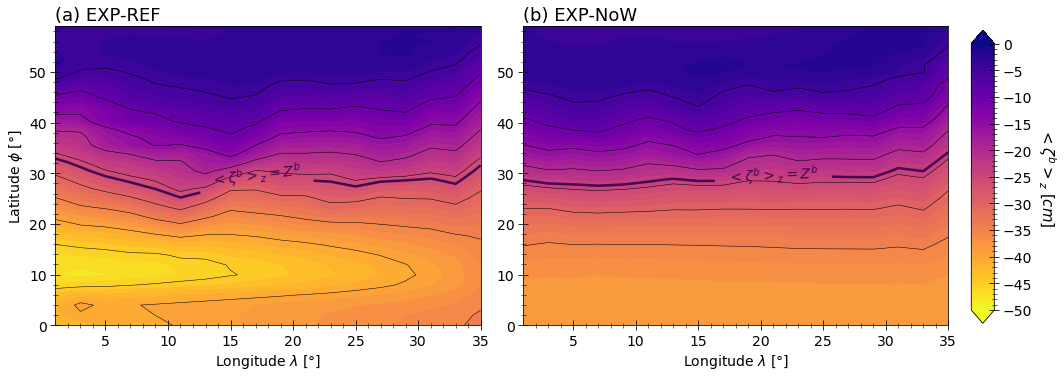

In [34]:
fig, ax = plt.subplots(1,2,figsize=(16,5.5))
vmin = -50
vmax = 0
for i, exp in enumerate(['EXP00_1d10','EXP01_1d10']):
    # qcs=ax[i].contourf(XY, YX, h_vm[exp].mean('t')-ds[exp].zgDE.mean('t'), cmap=cmap_OB,extend='both', levels=np.linspace(vmin,vmax,41))
    
    zeta_vm = grid_ops[exp].average(h[exp], 'Z')-grid_ops[exp].average(h_gm[exp], 'Z')
    # zeta_gm = {exp: grid_ops[exp].average(h[exp], ['X','Y','Z']).mean('t')-grid_ops[exp].average(h_gm[exp], ['X','Y']).mean('t').compute() for exp in ds}
    qcs=ax[i].contourf(XY, YX, zeta_vm.mean('t')*100, cmap=cmap_reversed,extend='both', levels=np.linspace(vmin,vmax,41))
    cs1=ax[i].contour(XY, YX, zeta_vm.mean('t')*100, 
                     levels=np.arange(-50,5,5), colors='k',linewidths=.5, negative_linestyles='solid',linestyles='solid')
    cs=ax[i].contour(XY, YX, zeta_vm.mean('t')*100, 
                     levels=[(ds[exp].zgDE.mean('t')-ds[exp].zgDE_gm.mean('t'))*100], color='k')
    fmt = {}
    strs = [r'$<\zeta^b>_z= Z^b$']
    for l, s in zip(cs.levels, strs):
        fmt[l] = s

    # Label every other level using strings
    ax[i].clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=14)

    # c = ax[i].contour(YZ, ZY, ds[exp].psi.mean('t')[:-1], colors='k',levels=np.linspace(0,6,7),linewidths=1.3,alpha=.7)
    # ax[i].hlines(ds[exp].zg_0.mean('t'),0,60, color='grey',label='$z_g^b$')
    # ax[i].clabel(c)
    #ax[i].set_title('(b) Meridional overturning circulation',fontsize=18)
    ax[i].set_xlabel('Longitude $\lambda$ [°]',fontsize=14)
    # ax[i].set_yticks([-4000,-3000,-2000,-1000,0])
    # ax[i].set_yticklabels([0,-1,-2,-3,-4][::-1])
    # ax[i].set_ylim(-3800,0)
    ax[i].set_xlim(1,35) 
    ax[i].set_ylim(0,59)

    prefix = ['(a) ','(b) '] 
    prefix1 = ['EXP-REF ','EXP-NoW '] 
    suffix = [r'Height anomaly $\zeta^b$', r'Height anomaly $\zeta^b$']
    ax[i].set_title(prefix[i]+prefix1[i],fontsize=18,loc='left')
    # ax[i].legend(fontsize=14,handlelength=1,loc='lower left')
ax[0].set_ylabel('Latitude $\phi$ [°]',fontsize=14)
ax_cb=fig.add_axes([0.92, 0.13, 0.02, 0.74])
cbar=plt.colorbar(ScalarMappable(norm=qcs.norm, cmap=qcs.cmap),ax=ax_cb,cax=ax_cb,
             ticks=np.linspace(vmin,vmax,11),
             extend='both', pad=0.02)

# cbar.set_ticklabels([str(round(i,0)) for i in np.linspace(vmin,vmax,11)])
cbar.set_label(r'$<\zeta^b>_z$ [$cm$]',rotation=-90,labelpad=25,fontsize=15)

plt.subplots_adjust(wspace=0.1)
plt.savefig('figures/Fig4_final_revised.pdf', dpi=150, transparent=False, bbox_inches='tight')

/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


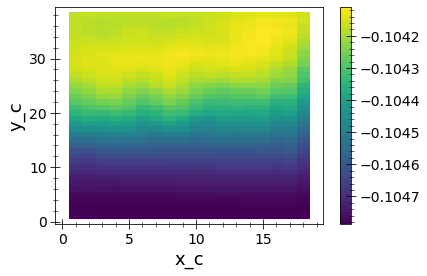

In [14]:
grid_ops[exp].average(h_gm[exp], 'Z').mean('t').plot()

/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


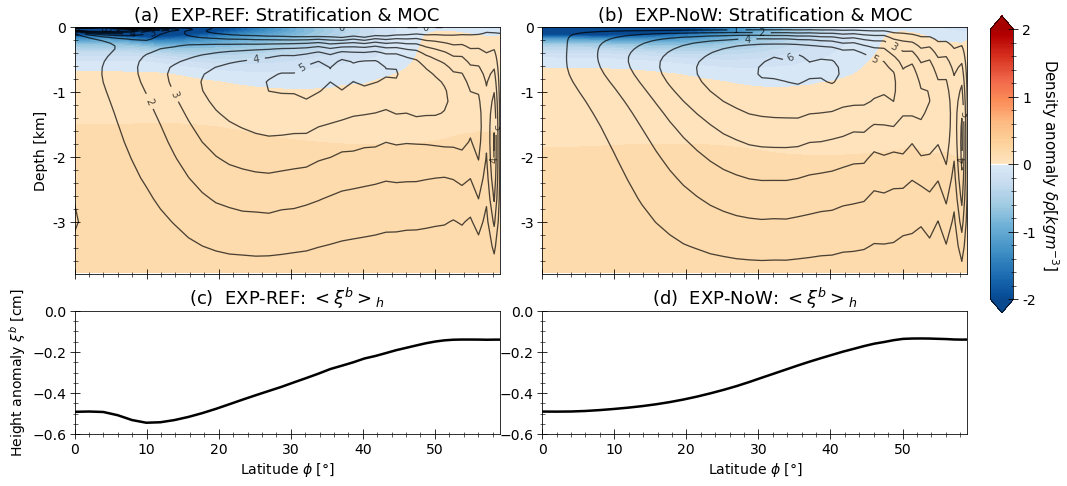

In [35]:
fig, ax = plt.subplots(2,2,figsize=(16,7.5), gridspec_kw= dict(height_ratios=[2,1]))

for i, exp in enumerate(['EXP00_1d10','EXP01_1d10']):
    if i==2: continue
    drho = ds[exp].rho-ds[exp].rho_gm
    drho_h = grid_ops[exp].average(drho,'X').mean('t')#.values-1000
    vmin = -2
    vmax = 2
    qcs=ax[0,i].contourf(YZ, ZY, drho_h[:-1], cmap=cmap_OB,extend='both', levels=np.linspace(-2,2,41))
    
    vmin=-6
    vmax=6
    c = ax[0,i].contour(YZ, ZY, ds[exp].psi.mean('t')[:-1], colors='k',levels=np.linspace(0,6,7),linewidths=1.3,alpha=.7)
    # ax[0,i].hlines(ds[exp].zg_0.mean('t'),0,60, color='grey',label='$z_g^b$')
    ax[0,i].clabel(c)
    #ax[i].set_title('(b) Meridional overturning circulation',fontsize=18)
    ax[0,i].set_yticks([-4000,-3000,-2000,-1000,0])
    ax[0,i].set_yticklabels([0,-1,-2,-3,-4][::-1])
    ax[0,i].set_ylim(-3800,0)
    ax[0,i].set_xlim(0,59) 
    ax[0,i].set_xticklabels([])

    prefix = ['(a)  ','(b)  '] 
    prefix1 = ['EXP-REF: ','EXP-NoW: '] 
    suffix = ['Stratification & MOC', 'Stratification & MOC']
    ax[0,i].set_title(prefix[i]+prefix1[i]+suffix[i],fontsize=18)
    # ax[i].legend(fontsize=14,handlelength=1,loc='lower left')
ax[0,0].set_ylabel('Depth [km]',fontsize=14)
ax_cb=fig.add_axes([0.92, 0.35, 0.02, 0.55])
cbar=plt.colorbar(ScalarMappable(norm=qcs.norm, cmap=qcs.cmap),ax=ax_cb,cax=ax_cb,
             ticks=np.arange(vmin, vmax+1, 1),
             extend='both', pad=0.02)

cbar.set_ticklabels(cbar.get_ticks())
#cbar.set_label('$\Psi_{moc}$ [Sv]',rotation=-90,labelpad=25,fontsize=15)
cbar.set_label(r'Density anomaly $\delta \rho$[$kg m^{-3}$]',rotation=-90,labelpad=25,fontsize=15)

for i, exp in enumerate(['EXP00_1d10','EXP01_1d10']):
    # h_vm = {exp: grid_ops[exp].average(h[exp], 'Z') for exp in ds}
    ax[1,i].plot(phi, grid_ops[exp].average(h[exp], ['X','Z']).mean('t'), c='k')

    ax[1,i].set_xlabel('Latitude $\phi$ [°]',fontsize=14)
    ax[1,i].set_xlim(0,59) 
    ax[1,i].set_ylim(-0.6,0)
    # ax[1,i].set_ylim()

    prefix = ['(c)  ','(d)  '] 
    prefix1 = ['EXP-REF: ','EXP-NoW: '] 
    suffix = [r'$<\xi^b>_h$', r'$<\xi^b>_h$']
    ax[1,i].set_title(prefix[i]+prefix1[i]+suffix[i],fontsize=18)
    # ax[i].legend(fontsize=14,handlelength=1,loc='lower left')

ax[1,0].set_ylabel(r'Height anomaly $\xi^b$ [cm]', fontsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.savefig('figures/Fig3_review.png', dpi=150, transparent=True, bbox_inches='tight')

/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/climategu/users/x_bensc/Analysis/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


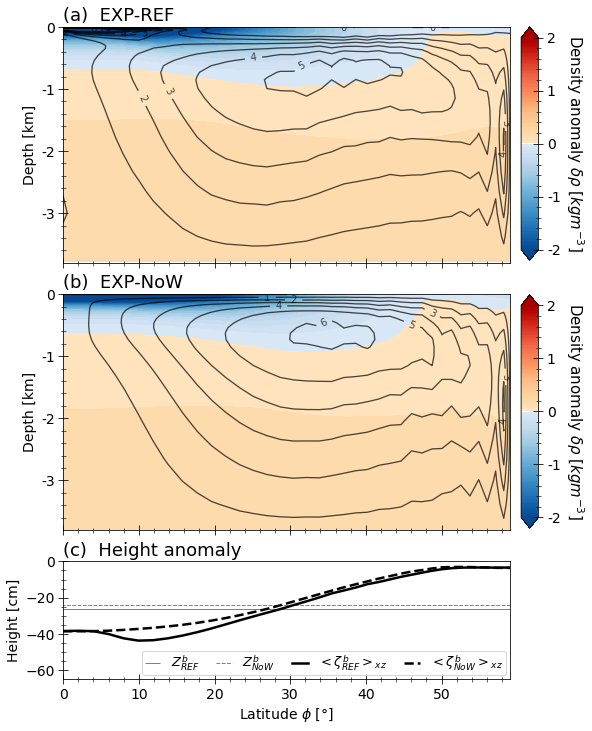

In [35]:
fig, ax = plt.subplots(3,figsize=(8,12), gridspec_kw= dict(height_ratios=[2,2,1]))

ax_cb=[fig.add_axes([0.92, 0.3, 0.03, 0.27]), fig.add_axes([0.92, 0.61, 0.03, 0.27])]
for i, exp in enumerate(['EXP00_1d10','EXP01_1d10']):
    if i==2: continue
    drho = ds[exp].rho-ds[exp].rho_gm
    drho_h = grid_ops[exp].average(drho,'X').mean('t')#.values-1000
    vmin = -2
    vmax = 2
    qcs=ax[i].contourf(YZ, ZY, drho_h[:-1], cmap=cmap_OB,extend='both', levels=np.linspace(-2,2,41))
    
    vmin=-6
    vmax=6
    c = ax[i].contour(YZ, ZY, ds[exp].psi.mean('t')[:-1], colors='k',levels=np.linspace(0,6,7),linewidths=1.3,alpha=.7)
    # ax[i].hlines(ds[exp].zg_0.mean('t'),0,60, color='grey',label='$z_g^b$')
    ax[i].clabel(c)
    #ax[i].set_title('(b) Meridional overturning circulation',fontsize=18)
    ax[i].set_yticks([-4000,-3000,-2000,-1000,0])
    ax[i].set_yticklabels([0,-1,-2,-3,-4][::-1])
    ax[i].set_ylim(-3800,0)
    ax[i].set_xlim(0,59) 
    ax[i].set_xticklabels([])
    ax[i].set_ylabel('Depth [km]',fontsize=14)

    prefix = ['(a)  ','(b)  '] 
    prefix1 = ['EXP-REF ','EXP-NoW'] 
    suffix = ['', '']
    ax[i].set_title(prefix[i]+prefix1[i]+suffix[i],fontsize=18, loc='left')
    
    cbar=plt.colorbar(ScalarMappable(norm=qcs.norm, cmap=qcs.cmap),ax=ax_cb[i],cax=ax_cb[i],
                ticks=np.arange(vmin, vmax+1, 1),
                extend='both', pad=0.02)
    # ax[i].legend(fontsize=14,handlelength=1,loc='lower left')
# ax_cb=fig.add_axes([0.92, 0.35, 0.02, 0.55])
# cbar=plt.colorbar(ScalarMappable(norm=qcs.norm, cmap=qcs.cmap),ax=ax_cb,cax=ax_cb,
#              ticks=np.arange(vmin, vmax+1, 1),
#              extend='both', pad=0.02)

    cbar.set_ticklabels(cbar.get_ticks())
    #cbar.set_label('$\Psi_{moc}$ [Sv]',rotation=-90,labelpad=25,fontsize=15)
    cbar.set_label(r'Density anomaly $\delta \rho$ [$kg m^{-3}$]',rotation=-90,labelpad=25,fontsize=15)

styles=['-','--']
labels=[r'$<\zeta^b_{REF}>_{xz}$', r'$<\zeta^b_{NoW}>_{xz}$']
labels2=[r'$Z^b_{REF}$', r'$Z^b_{NoW}$']
for i, exp in enumerate(['EXP00_1d10','EXP01_1d10']):
    ax[2].hlines(ds[exp].zgDE.mean('t')*100-ds[exp].zgDE_gm.mean('t')*100,-1,61, color='grey',linestyle=styles[i], label=labels2[i],linewidth=1)
for i, exp in enumerate(['EXP00_1d10','EXP01_1d10']):
    # h_vm = {exp: grid_ops[exp].average(h[exp], 'Z') for exp in ds}
    ax[2].plot(phi, zeta_xz[exp]*100, c='k',linestyle=styles[i], label=labels[i])
ax[2].legend(fontsize=13, handlelength=1.2, loc='lower right',ncol=4,labelspacing=0.3,columnspacing=1.3,borderaxespad=0.3,
             borderpad=0.2)
ax[2].set_xlabel('Latitude $\phi$ [°]',fontsize=14)
ax[2].set_xlim(0,59) 
ax[2].set_ylim(-65,0)
# ax[2].set_ylim()

prefix = ['(c)  ',] 
prefix1 = ['EXP-REF: ','EXP-NoW: '] 
suffix = [r'Height anomaly']
ax[2].set_title(prefix[0]+suffix[0],fontsize=18, loc='left')
    # ax[i].legend(fontsize=14,handlelength=1,loc='lower left')

ax[2].set_ylabel(r'Height [cm]', fontsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0.16)
plt.savefig('figures/Fig3_final_revised.pdf', dpi=150, transparent=True, bbox_inches='tight')